<a href="https://colab.research.google.com/github/uditmanav17/DL-with-Python/blob/master/Ch_7_1_Keras_functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7.1 Going beyond the Sequential model: the Keras functional API
Until now, all neural networks introduced in this book have been implemented using the Sequential model. The Sequential model makes the assumption that the network has exactly one input and exactly one output, and that it consists of a linear stack of layers.

This is a commonly verified assumption; the configuration is so common that we’ve been able to cover many topics and practical applications in these pages so far using only the Sequential model class. But this set of assumptions is too inflexible in a number of cases. Some networks require several independent inputs, others require multiple outputs, and some networks have internal branching between layers that makes them look like graphs of layers rather than linear stacks of layers.
 
Some tasks, for instance, require multimodal inputs: they merge data coming from different input sources, processing each type of data using different kinds of neural layers. Imagine a deep-learning model trying to predict the most likely market price of a second-hand piece of clothing, using the following inputs: user-provided metadata (such as the item’s brand, age, and so on), a user-provided text description, and a picture of the item. If you had only the metadata available, you could one-hot encode it and use a densely connected network to predict the price. If you had only the text description available, you could use an RNN or a 1D convnet. If you had only the picture, you could use a 2D convnet. But how can you use all three at the same time? A naive approach would be to train three separate models and then do a weighted average of their predictions. But this may be suboptimal, because the information extracted by the models may be redundant. A better way is to jointly learn a more accurate model of the data by using a model that can see all available input modalities simultaneously: a model with three input branches.

Similarly, some tasks need to predict multiple target attributes of input data. Given the text of a novel or short story, you might want to automatically classify it by genre (such as romance or thriller) but also predict the approximate date it was written. Of course, you could train two separate models: one for the genre and one for the date. But because these attributes aren’t statistically independent, you could build a better model by learning to jointly predict both genre and date at the same time. Such a joint model would then have two outputs, or heads. Due to correlations between genre and date, knowing the date of a novel would help the model learn rich, accurate representations of the space of novel genres, and vice versa.

Additionally, many recently developed neural architectures require nonlinear network topology: networks structured as directed acyclic graphs. The Inception family of networks (developed by Szegedy et al. at Google), for instance, relies on Inception modules, where the input is processed by several parallel convolutional branches whose outputs are then merged back into a single tensor. There’s also the recent trend of adding residual connections to a model, which started with the ResNet family of networks (developed by He et al. at Microsoft). A residual connection consists of reinjecting previous representations into the downstream flow of data by adding a past output tensor to a later output tensor, which helps prevent information loss along the data-processing flow. There are many other examples of such graph-like networks.

These three important use cases—multi-input models, multi-output models, and graph-like models—aren’t possible when using only the Sequential model class in Keras. But there’s another far more general and flexible way to use Keras: the functional API. This section explains in detail what it is, what it can do, and how to use it.

### 7.1.1 Introduction to the functional API
In the functional API, you directly manipulate tensors, and you use layers as functions that take tensors and return tensors (hence, the name functional API):
```
from keras import Input, layers
input_tensor = Input(shape=(32,))  # tensor
dense = layers.Dense(32, activation='relu')  # layer function
output_tensor = dense(input_tensor)  # A layer may be called on a tensor, and it returns a tensor
```
Let’s start with a minimal example that shows side by side a simple Sequential model and its equivalent in the functional API:


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


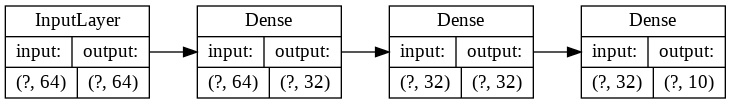

In [7]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras import layers
from keras import Input

# sequential model
seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))
seq_model.summary()
tf.keras.utils.plot_model(
    seq_model, 
    # to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False,
    rankdir='LR', # LR TB
    expand_nested=True, 
    dpi=96
)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


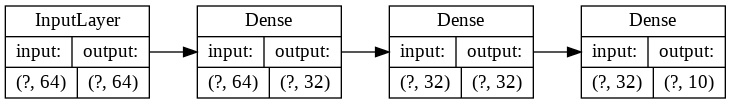

In [8]:
# functional equivalent
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model = Model(input_tensor, output_tensor)
model.summary()
tf.keras.utils.plot_model(
    model, 
    # to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False,
    rankdir='LR', # LR TB
    expand_nested=True, 
    dpi=96
)

The only part that may seem a bit magical at this point is instantiating a Model object using only an input tensor and an output tensor. Behind the scenes, Keras retrieves every layer involved in going from input_tensor to output_tensor, bringing them together into a graph-like data structure—a Model. Of course, the reason it works is that output_tensor was obtained by repeatedly transforming input_tensor. If you tried to build a model from inputs and outputs that weren’t related, you’d get a RuntimeError:
```
unrelated_input = Input(shape=(32,))
bad_model = model = Model(unrelated_input, output_tensor)
```
```
ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(None, 64), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []
```
This error tells you, in essence, that Keras couldn’t reach input_1 from the provided output tensor. When it comes to compiling, training, or evaluating such an instance of Model, the API is the same as that of Sequential:


In [4]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy') # compiles model

# dummy data
import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))

# train and eval model 
model.fit(x_train, y_train, epochs=10, batch_size=128)
score = model.evaluate(x_train, y_train)
print(score)

Epoch 1/10
1000/1000 [==============================] - 0s 71us/step - loss: 46.1874
Epoch 2/10
1000/1000 [==============================] - 0s 15us/step - loss: 53.0567
Epoch 3/10
1000/1000 [==============================] - 0s 14us/step - loss: 58.1776
Epoch 4/10
1000/1000 [==============================] - 0s 14us/step - loss: 62.9456
Epoch 5/10
1000/1000 [==============================] - 0s 14us/step - loss: 67.7849
Epoch 6/10
1000/1000 [==============================] - 0s 13us/step - loss: 72.3573
Epoch 7/10
1000/1000 [==============================] - 0s 14us/step - loss: 77.0209
Epoch 8/10
1000/1000 [==============================] - 0s 14us/step - loss: 82.5407
Epoch 9/10
1000/1000 [==============================] - 0s 14us/step - loss: 87.4749
Epoch 10/10
1000/1000 [==============================] - 0s 36us/step
95.75782995605469


### 7.1.2 Multi-input models
The functional API can be used to build models that have multiple inputs. Typically, such models at some point merge their different input branches using a layer that can combine several tensors: by adding them, concatenating them, and so on. This is usually done via a Keras merge operation such as keras.layers.add, keras.layers .concatenate, and so on. Let’s look at a very simple example of a multi-input model: a question-answering model.

A typical question-answering model has two inputs: a natural-language question and a text snippet (such as a news article) providing information to be used for answering the question. The model must then produce an answer: in the simplest possible setup, this is a one-word answer obtained via a softmax over some predefined vocabulary.

Following is an example of how you can build such a model with the functional API. You set up two independent branches, encoding the text input and the question input as representation vectors; then, concatenate these vectors; and finally, add a softmax classifier on top of the concatenated representations. 


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 10000)  640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 10000)  320000      question[0][0]                   
____________________________________________________________________________________________

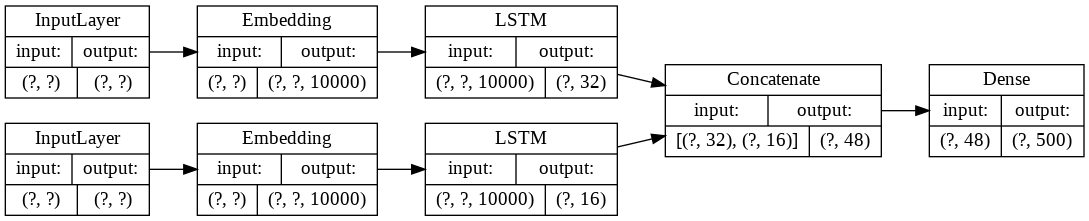

In [1]:
# Functional API implementation of a two-input question-answering model
from keras.models import Model
from keras import layers
from keras import Input
import tensorflow as tf

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# The text input is a variablelength sequence of integers. Note that you can optionally name the inputs.
text_input = Input(shape=(None,), dtype='int32', name='text')

# Embeds the inputs into a sequence of vectors of size 64
embedded_text = layers.Embedding(64, text_vocabulary_size)(text_input)

# Encodes the vectors in a single vector via an LSTM
encoded_text = layers.LSTM(32)(embedded_text)

question_input = Input(shape=(None,),dtype='int32',name='question')
embedded_question = layers.Embedding(32, question_vocabulary_size)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)

# Concatenates the encoded question and encoded text
concatenated = layers.concatenate([encoded_text, encoded_question],axis=-1)

# Adds a softmax classifier on top
answer = layers.Dense(answer_vocabulary_size,activation='softmax')(concatenated)

# At model instantiation, you specify the two inputs and the output.
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['acc'])
model.summary()

tf.keras.utils.plot_model(
    model, 
    # to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False,
    rankdir='LR', # LR TB
    expand_nested=True, 
    # dpi=96
)

Now, how do you train this two-input model? There are two possible APIs: you can feed the model a list of Numpy arrays as inputs, or you can feed it a dictionary that maps input names to Numpy arrays. Naturally, the latter option is available only if you give names to your inputs.

In [2]:
# Feeding data to a multi-input model
import numpy as np

num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocabulary_size,  # generates dummy numpy data
                         size=(num_samples, max_length))
print(f"text - {text}")
print(f"text shape - {text.shape}")
question = np.random.randint(1, question_vocabulary_size,
                             size=(num_samples, max_length))
print(f"question - {question}")
print(f"question shape - {question.shape}")
answers = np.random.randint(0, 1, # answers are one-hot encoded, not integers
                            size=(num_samples, answer_vocabulary_size))
print(f"answers - {answers}")
print(f"answers shape - {answers.shape}")

text - [[8028 7254 4699 ... 3972 3896 3670]
 [1199 8739 6391 ... 8552 3207 1698]
 [8436  267  127 ... 1486 8214 7230]
 ...
 [3207 8518 2552 ... 3844 9790 7794]
 [8768 5408 7968 ... 4364 6512 7768]
 [7383 7800 5389 ... 4721 3307 1868]]
text shape - (1000, 100)
question - [[8043 6704 6550 ... 8436 6677 2294]
 [8946 6821 7466 ... 9553 6814  378]
 [6088 3388 7022 ... 3808 8844 8132]
 ...
 [4650 4046 3046 ... 4713 7681 2421]
 [1501 9023 8011 ... 7393 1723 2589]
 [9500 6028 5966 ... 2553 2331  231]]
question shape - (1000, 100)
answers - [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
answers shape - (1000, 500)


In [4]:
# fitting using list of inputs
model.fit([text, question], answers, epochs=10, batch_size=128)

# Fitting using a dictionary of inputs (only if inputs are named)
# model.fit({'text': text, 'question': question}, 
#           answers,
#           epochs=10, 
#           batch_size=128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - acc: 0.0780
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 9/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 10/10
1000/1000 [==============================] - 3s

### 7.1.3 Multi-output models
In the same way, you can use the functional API to build models with multiple outputs (or multiple heads). A simple example is a network that attempts to simultaneously predict different properties of the data, such as a network that takes as input a series of social media posts from a single anonymous person and tries to predict attributes of that person, such as age, gender, and income level.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 50000)  12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    32000128    embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, None, 128)    0           conv1d_1[0][0]                   
____________________________________________________________________________________________

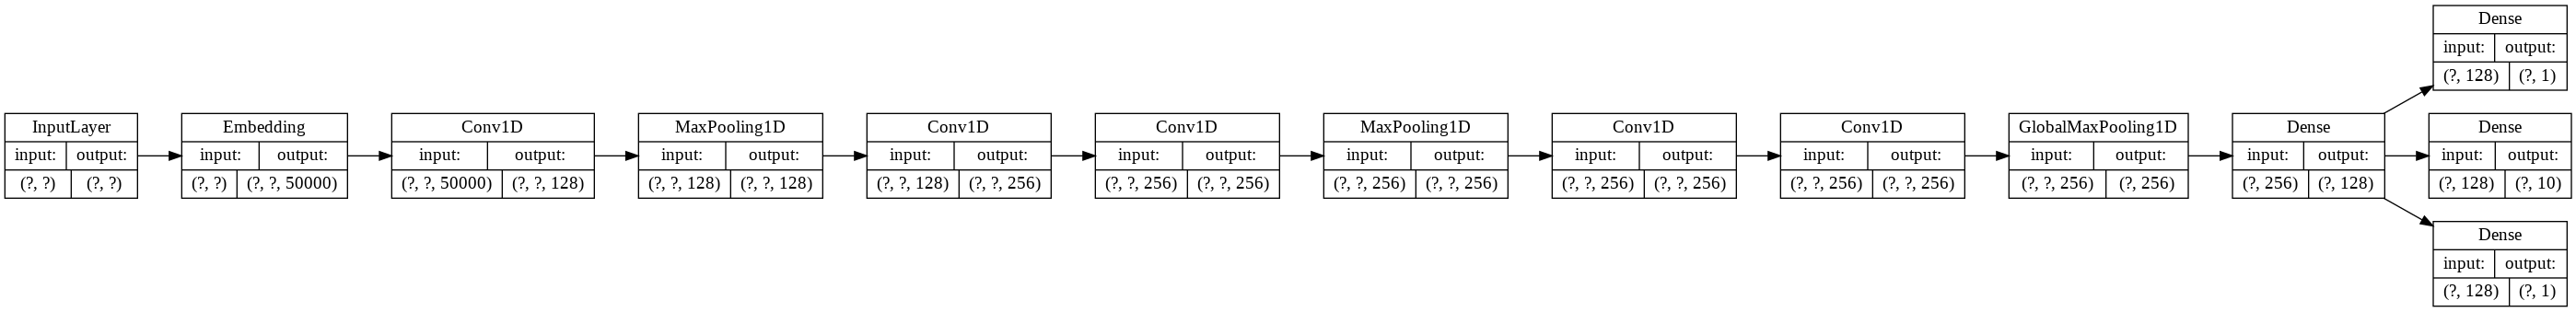

In [5]:
# Functional API implementation of a three-output model
from keras import layers
from keras import Input
from keras.models import Model

vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(256, vocabulary_size)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups,
                                 activation='softmax',
                                 name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)
model = Model(posts_input,
              [age_prediction, income_prediction, gender_prediction])
model.summary()

tf.keras.utils.plot_model(
    model, 
    # to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False,
    rankdir='LR', # LR TB
    expand_nested=True, 
    # dpi=96
)

Importantly, training such a model requires the ability to specify different loss functions for different heads of the network: for instance, age prediction is a scalar regression task, but gender prediction is a binary classification task, requiring a different training procedure. But because gradient descent requires you to minimize a scalar, you must combine these losses into a single value in order to train the model. The simplest way to combine different losses is to sum them all. In Keras, you can use either a list or a dictionary of losses in compile to specify different objects for different outputs; the resulting loss values are summed into a global loss, which is minimized during training.

In [0]:
# model.compile(optimizer='rmsprop',
#               loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

model.compile(optimizer='rmsprop',
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'})

Note that very imbalanced loss contributions will cause the model representations to be optimized preferentially for the task with the largest individual loss, at the expense of the other tasks. To remedy this, you can assign different levels of importance to the loss values in their contribution to the final loss. This is useful in particular if the losses’ values use different scales. For instance, the mean squared error (MSE) loss used for the age-regression task typically takes a value around 3–5, whereas the crossentropy loss used for the gender-classification task can be as low as 0.1. In such a situation, to balance the contribution of the different losses, you can assign a weight of 10 to the crossentropy loss and a weight of 0.25 to the MSE loss.

In [0]:
# Compilation options of a multi-output model: loss weighting
# model.compile(optimizer='rmsprop',
#               loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
#               loss_weights=[0.25, 1., 10.])

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

Much as in the case of multi-input models, you can pass Numpy data to the model for training either via a list of arrays or via a dictionary of arrays.
```
# Feeding data to a multi-output model
# age_targets, income_targets, and gender_targets are assumed to be Numpy arrays
model.fit(posts, [age_targets, income_targets, gender_targets],
          epochs=10, batch_size=64)

model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64)
```          

### 7.1.4 Directed acyclic graphs of layers
With the functional API, not only can you build models with multiple inputs and multiple outputs, but you can also implement networks with a complex internal topology. Neural networks in Keras are allowed to be arbitrary directed acyclic graphs of layers. The qualifier acyclic is important: these graphs can’t have cycles. It’s impossible for a tensor x to become the input of one of the layers that generated x. The only processing loops that are allowed (that is, recurrent connections) are those internal to recurrent layers.

Several common neural-network components are implemented as graphs. Two notable ones are Inception modules and residual connections. To better understand how the functional API can be used to build graphs of layers, let’s take a look at how you can implement both of them in Keras.


#### INCEPTION MODULES
Inception3 is a popular type of network architecture for convolutional neural networks; it was developed by Christian Szegedy and his colleagues at Google in 2013–2014, inspired by the earlier network-in-network architecture. It consists of a stack of modules that themselves look like small independent networks, split into several parallel branches. The most basic form of an Inception module has three to four branches starting with a 1 × 1 convolution, followed by a 3 × 3 convolution, and ending with the concatenation of the resulting features. This setup helps the network separately learn spatial features and channel-wise features, which is more efficient than learning them jointly. More-complex versions of an Inception module are also possible, typically involving pooling operations, different spatial convolution sizes (for example, 5 × 5 instead of 3 × 3 on some branches), and branches without a spatial convolution (only a 1 × 1 convolution).

![Inception Module from Inception V3](https://drive.google.com/uc?id=1-OsWTNp4FRkii-wrjvJCjfsXtFjuzZzR)

####The purpose of 1 × 1 convolutions
You already know that convolutions extract spatial patches around every tile in an input tensor and apply the same transformation to each patch. An edge case is when the patches extracted consist of a single tile. The convolution operation then becomes equivalent to running each tile vector through a Dense layer: it will compute features that mix together information from the channels of the input tensor, but it won’t mix information across space (because it’s looking at one tile at a time). Such 1 × 1 convolutions (also called pointwise convolutions) are featured in Inception modules, where they contribute to factoring out channel-wise feature learning and spacewise feature learning—a reasonable thing to do if you assume that each channel is highly autocorrelated across space, but different channels may not be highly correlated with each other.
<br>
<br>
Here’s how you’d implement the module featured in figure 7.8 using the functional API. This example assumes the existence of a 4D input tensor x:
```
# Every branch has the same stride value (2), 
# which is necessary to keep all branch outputs the same size so you can concatenate them
branch_a = layers.Conv2D(filters = 128, kernel_size = 1, activation='relu', strides=2)(x)

# In this branch, the striding occurs in the spatial convolution layer
branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

# In this branch, the striding occurs in the average pooling layer.
branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 3, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_d)

# Concatenates the branch outputs to obtain the module output
output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)
```

Note that the full Inception V3 architecture is available in Keras as ***keras.applications.inception_v3.InceptionV3***, including weights pretrained on the ImageNet dataset. Another closely related model available as part of the Keras applications module is Xception. Xception, which stands for extreme inception, is a convnet architecture loosely inspired by Inception. It takes the idea of separating the learning of channel-wise and space-wise features to its logical extreme, and replaces Inception modules with depthwise separable convolutions consisting of a depthwise convolution (a spatial convolution where every input channel is handled separately) followed by a pointwise convolution (a 1 × 1 convolution)—effectively, an extreme form of an Inception module, where spatial features and channel-wise features are fully separated. Xception has roughly the same number of parameters as Inception V3, but it shows better runtime performance and higher accuracy on ImageNet as well as other large-scale datasets, due to a more efficient use of model parameters. 

#### RESIDUAL CONNECTIONS
Residual connections are a common graph-like network component found in many post- 2015 network architectures, including Xception. They were introduced by He et al. from Microsoft in their winning entry in the ILSVRC ImageNet challenge in late 2015.6 They tackle two common problems that plague any large-scale deep-learning model: vanishing gradients and representational bottlenecks. In general, adding residual connections to any model that has more than 10 layers is likely to be beneficial.

A residual connection consists of making the output of an earlier layer available as input to a later layer, effectively creating a shortcut in a sequential network. Rather than being concatenated to the later activation, the earlier output is summed with the later activation, which assumes that both activations are the same size. If they’re different sizes, you can use a linear transformation to reshape the earlier activation into the target shape (for example, a Dense layer without an activation or, for convolutional feature maps, a 1 × 1 convolution without an activation).

Here’s how to implement a residual connection in Keras when the feature-map sizes are the same, using identity residual connections. This example assumes the existence of a 4D input tensor x:

```
x = ...

# applies transformation to x
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# adds original x back to output features
y = layers.add([y, x])
```

And the following implements a residual connection when the feature-map sizes differ, using a linear residual connection (again, assuming the existence of a 4D input tensor x):

```
x = ...

y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# Uses a 1 × 1 convolution to linearly downsample the original x tensor to the same shape as y
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

# Adds the residual tensor back to the output features
y = layers.add([y, residual])
```

#### Representational bottlenecks in deep learning
In a Sequential model, each successive representation layer is built on top of the previous one, which means it only has access to information contained in the activation of the previous layer. If one layer is too small (for example, it has features that are too low-dimensional), then the model will be constrained by how much information can be crammed into the activations of this layer. 

You can grasp this concept with a signal-processing analogy: if you have an audioprocessing pipeline that consists of a series of operations, each of which takes as input the output of the previous operation, then if one operation crops your signal to a low-frequency range (for example, 0–15 kHz), the operations downstream will never be able to recover the dropped frequencies. Any loss of information is permanent. Residual connections, by reinjecting earlier information downstream, partially solve this issue for deep-learning models.

#### Vanishing gradients in deep learning
Backpropagation, the master algorithm used to train deep neural networks, works by propagating a feedback signal from the output loss down to earlier layers. If this feedback signal has to be propagated through a deep stack of layers, the signal may become tenuous or even be lost entirely, rendering the network untrainable. This issue is known as vanishing gradients. 

This problem occurs both with deep networks and with recurrent networks over very long sequences—in both cases, a feedback signal must be propagated through a long series of operations. You’re already familiar with the solution that the LSTM layer uses to address this problem in recurrent networks: it introduces a carry track that propagates information parallel to the main processing track. Residual connections work in a similar way in feedforward deep networks, but they’re even simpler: they introduce a purely linear information carry track parallel to the main layer stack, thus helping to propagate gradients through arbitrarily deep stacks of layers.

### 7.1.5 Layer weight sharing
One more important feature of the functional API is the ability to reuse a layer instance several times. When you call a layer instance twice, instead of instantiating a new layer for each call, you reuse the same weights with every call. This allows you to build models that have shared branches—several branches that all share the same knowledge and perform the same operations. That is, they share the same representations and learn these representations simultaneously for different sets of inputs.

For example, consider a model that attempts to assess the semantic similarity between two sentences. The model has two inputs (the two sentences to compare) and outputs a score between 0 and 1, where 0 means unrelated sentences and 1 means sentences that are either identical or reformulations of each other. Such a model could be useful in many applications, including deduplicating natural-language queries in a dialog system.

In this setup, the two input sentences are interchangeable, because semantic similarity is a symmetrical relationship: the similarity of A to B is identical to the similarity of B to A. For this reason, it wouldn’t make sense to learn two independent models for processing each input sentence. Rather, you want to process both with a single LSTM layer. The representations of this LSTM layer (its weights) are learned based on both inputs simultaneously. This is what we call a Siamese LSTM model or a shared LSTM.

Here’s how to implement such a model using layer sharing (layer reuse) in the Keras functional API:



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           20608       input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64)           0           lstm_2[0][0]               

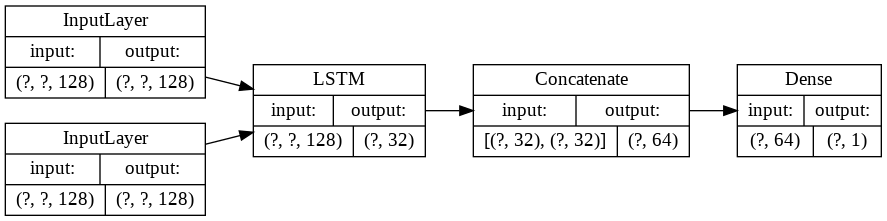

In [2]:
import tensorflow as tf
from keras import layers
from keras import Input
from keras.models import Model

lstm = layers.LSTM(32)  # init single LSTM layer once

# Building the left branch of the model: inputs are variable-length sequences of vectors of size 128.
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

# Building the right branch of the model: when you call an existing layer instance, you reuse its weights
right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

# Builds the classifier on top
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# Instantiating and training the model: when you train such a model, 
# the weights of the LSTM layer are updated based on both inputs.
model = Model([left_input, right_input], predictions)
# model.fit([left_data, right_data], targets)
model.summary()

tf.keras.utils.plot_model(
    model, 
    # to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False,
    rankdir='LR', # LR TB
    expand_nested=True, 
    # dpi=96
)

Naturally, a layer instance may be used more than once—it can be called arbitrarily many times, reusing the same set of weights every time.

### 7.1.6 Models as layers
Importantly, in the functional API, models can be used as you’d use layers—effectively, you can think of a model as a “bigger layer.” This is true of both the Sequential and Model classes. This means you can call a model on an input tensor and retrieve an output tensor:
```
y = model(x)
```
If the model has multiple input tensors and multiple output tensors, it should be called with a list of tensors:
```
y1, y2 = model([x1, x2])
```
When you call a model instance, you’re reusing the weights of the model—exactly like what happens when you call a layer instance. Calling an instance, whether it’s a layer instance or a model instance, will always reuse the existing learned representations of the instance—which is intuitive.

One simple practical example of what you can build by reusing a model instance is a vision model that uses a dual camera as its input: two parallel cameras, a few centimeters (one inch) apart. Such a model can perceive depth, which can be useful in many applications. You shouldn’t need two independent models to extract visual features from the left camera and the right camera before merging the two feeds. Such low-level processing can be shared across the two inputs: that is, done via layers that use the same weights and thus share the same representations. Here’s how you’d implement a Siamese vision model (shared convolutional base) in Keras:
```
from keras import layers
from keras import applications
from keras import Input

# The base image-processing model is the Xception network (convolutional base only)
xception_base = applications.Xception(weights=None, include_top=False)

# inputs inputs are 250 × 250 RGB images.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

# Calls the same vision model twice
left_features = xception_base(left_input)
right_features = xception_base(right_input)

# The merged features contain information from the right visual feed and the left visual feed
merged_features = layers.concatenate([left_features, right_input], axis=-1)
```

### 7.1.7 Wrapping up
This concludes our introduction to the Keras functional API—an essential tool for building advanced deep neural network architectures. Now you know the following:
* To step out of the Sequential API whenever you need anything more than a linear stack of layers
* How to build Keras models with several inputs, several outputs, and complex internal network topology, using the Keras functional API
* How to reuse the weights of a layer or model across different processing branches, by calling the same layer or model instance several times